## Challenge

The challenge is to generate adversarial examples for the digit 2 and get them to reclassify as 6.

The rules specify TensorFlow but the ground rules say any language can be used, and if that's the case then I'm also assuming that means it's flexible on libraries as well. I use mainly Lasagne, a deep learning library built on Theano for Python because I have experience with it. Sorry if it's not that readable for you and I'm happy to clarify any of the code.

In [3]:
#importing the necessary packages
import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device 6 failed:
initCnmem: cnmemInit call failed! Reason=CNMEM_STATUS_OUT_OF_MEMORY. numdev=1

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device gpu failed:
initCnmem: cnmemInit call failed! Reason=CNMEM_STATUS_OUT_OF_MEMORY. numdev=1



RuntimeError: ('initCnmem: cnmemInit call failed! Reason=CNMEM_STATUS_OUT_OF_MEMORY. numdev=1\n', 'You asked to force this device and it failed. No fallback to the cpu or other gpu device.')

In [16]:
from six.moves import cPickle
import matplotlib.pyplot as plt
%matplotlib inline

## Loading up the MNIST data

In [4]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
# Load the dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

## Finding ten images of 2

Specifically I am looking through the y_test variable, because the advesarial noise I am training it on was trained using the training set, so I don't want to use an overfit sample for testing.

In [20]:
two_indices = y_test == 2
two_samples = X_test[two_indices]

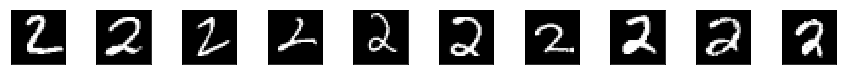

In [13]:
#Showing the first ten samples
fig, axes = plt.subplots(1, 10, figsize=(15, 1))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(10):

    axes[i].imshow(two_samples[i].reshape((28, 28)), cmap='gray')

    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Show cells
plt.show()

## Loading previously trained MNIST model

In [14]:
# Loading up my model

In [19]:
# Model architecture
def build_cnn(input_var=None):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    
    #conv layer 1
    network = lasagne.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform('relu'))
    
    #max pooling layer 1
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    #conv layer 2
    network = lasagne.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify)
    
    #max pooling layer 2
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    #Dense mapping to a fully connected layer with dropout (p=0.5)
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify)
    
    # A softmax output for digit classification
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=10,
        nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [22]:
# A quick function for plotting MNIST images
# A function to plot images, taking a list of images, the number of rows and cols
def plot_images(images, row, col, true_labels=None, false_labels=None):
    
    # Creating a figure of subplots
    fig, axes = plt.subplots(row, col)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        image = images[i].reshape((28, 28))
        
        ax.imshow(image, cmap='gray')
        
        if true_labels != None:
            ax.set_xlabel("True: {}, Pred: {}".format(true_labels[i], false_labels[i]))
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Show cells
    plt.show()

In [18]:
#Loading pretrained parameters
with open('trained_params.pkl', 'rb') as f:
    params = cPickle.load(f)

In [21]:
input_var = T.tensor4('inputs')

network = build_cnn(input_var)
lasagne.layers.set_all_param_values(network, params)

test_prediction = lasagne.layers.get_output(network)
output_fn = theano.function([input_var], T.argmax(test_prediction, axis=1))

inputs, targets = batch
pred = output_fn(two_samples)

NameError: name 'T' is not defined